# Loan Default Classification - Comparison of Decision Tree Methods
Nick Vastine
DTSA 5509 Introduction to Machine Learning: Supervised Learning
Final Project
June 25, 2024

## Project Topic
This project seeks to evaluate whether loan applications will default using binary classification decision tree methods (single decision tree, boosting, random forest).

The goal of the project is to evaluate the various approaches in decision trees based on resulting model accuracy. This analysis also includes sensitivity to hyperparameters, especially tree depth, and number of learner trees for ensemble methods.

An accurate classification model is valuable to banks to evaluate default risk during the loan application process. Further, it is valuable to understand the most important features for users to easily intuit classification without use of the algorithm.

## Data
The loan default data is sourced from [Kaggle] (https://www.kaggle.com/datasets/nikhil1e9/loan-default), originating from a [Coursera Coding Challenge] (https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction). A local copy of the data has been uploaded to this project's Github page.

The tabulated data is 255,347 samples with 18 features (8 Integer, 5 String, 3 Boolean, 2 Other). Some features of interest include loan features (LoanAmount, InterestRate, LoanTerm, LoanPurpose, etc.) and applicant features (Age, Income, CreditScore, Employment, MonthsEmployed, Education, etc.). 

The data is first imported, then the shape is printed with a complete list of features with their data types.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import sklearn as sk
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Loan Default Dataset.csv')
print("(Samples, Features) = ",df.shape)
print(df.dtypes)

(Samples, Features) =  (255347, 18)
LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object


## Data Cleaning
The data appears clean after a brief review in Excel. For example, there are no spelling errors or mixed data types within the same feature.

However, we will further clean our data by:
* Dropping any empty values
* Removing the unnecessary column LoanID which is an assigned identifier and should not inform risk of default
* Remap data types as necessary, in particular categorical features (ex. LoanPurpose) and reassigning "Yes/No" information to "1/0" as boolean correlation purposes (ex. HasMortgage). Note the categorical features are later cleansed further by encoding the string labels to numerical values.

In [3]:
# Dropping na values
df = df.dropna()
# Dropping LoanID column
df = df.drop(columns='LoanID')
# Converting 'Yes/No' to '1/0'
df['HasMortgage'] = df.HasMortgage.map(dict(Yes=1, No=0))
df['HasDependents'] = df.HasDependents.map(dict(Yes=1, No=0))
df['HasCoSigner'] = df.HasCoSigner.map(dict(Yes=1, No=0))
df['Default'] = df['Default'].replace(0,-1)

# Reassigning data types
df = df.astype({
    "Education":"category",
    "EmploymentType":"category",
    "MaritalStatus":"category",
    "HasMortgage":"boolean",
    "HasDependents":"boolean",
    "LoanPurpose":"category",
    "HasCoSigner":"boolean",
})

print("(Samples, Features) = ",df.shape)
# print(df.dtypes)

(Samples, Features) =  (255347, 17)


We can see from this analysis that all samples were retained after dropping empty values, reinforcing our claim of a relatively complete and clean dataset. This is further confirmed by reviewing the unique values of our categorical features to check for typos/variances and a description of our numerical features.

In [4]:
print("Education: ", df.Education.unique())
print("EmploymentType: ", df.EmploymentType.unique())
print("MaritalStatus: ", df.MaritalStatus.unique())
print("LoanPurpose: ", df.LoanPurpose.unique())
df.describe()

Education:  ['Bachelor's', 'Master's', 'High School', 'PhD']
Categories (4, object): ['Bachelor's', 'High School', 'Master's', 'PhD']
EmploymentType:  ['Full-time', 'Unemployed', 'Self-employed', 'Part-time']
Categories (4, object): ['Full-time', 'Part-time', 'Self-employed', 'Unemployed']
MaritalStatus:  ['Divorced', 'Married', 'Single']
Categories (3, object): ['Divorced', 'Married', 'Single']
LoanPurpose:  ['Other', 'Auto', 'Business', 'Home', 'Education']
Categories (5, object): ['Auto', 'Business', 'Education', 'Home', 'Other']


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,-0.767744
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.640759
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,-1.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,-1.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,-1.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,-1.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


We can conclude from our analysis the data is clean and ready for our exploratory data analysis. We will check the distributions of our variables in our Exploratory Data Analysis to identify any outliers or questionable trends.

## Exploratory Data Analysis
While our data is clean, we don't have a strong understanding of the data itself. This section explores the following considerations:

1. Label balance
2. Evaluating feature importance by correlation
3. Distributions (histograms) of features

### Label Balance
It is important to ensure our binary classification data has balanced labeling as excessively skewed data will bias our decision tree models.

The below code indicates only 11.6% of our sample points are labeled for default. We will adjust our classifier algorithms by weighing our defaulted samples more than the non-default samples (ie. class_weight = {-1:1, 1:7.6} where label 1 indicates default. 7.6 is derived by dividing the 88.4% of non-defaulted loans by the 11.6% of defaulted loans to weigh both classes equally).

In [5]:
DefaultPercent = 100*df[df["Default"]==1]["Default"].count()/df["Default"].count()
print("Default Percent: %.3f" % DefaultPercent)

Default Percent: 11.613


### Evaluating Feature Importance by Correlation
We will use a correlation matrix to identify important classification features. This plot will also indicate any colinearity between variables if we wanted to simplify our features for modeling.

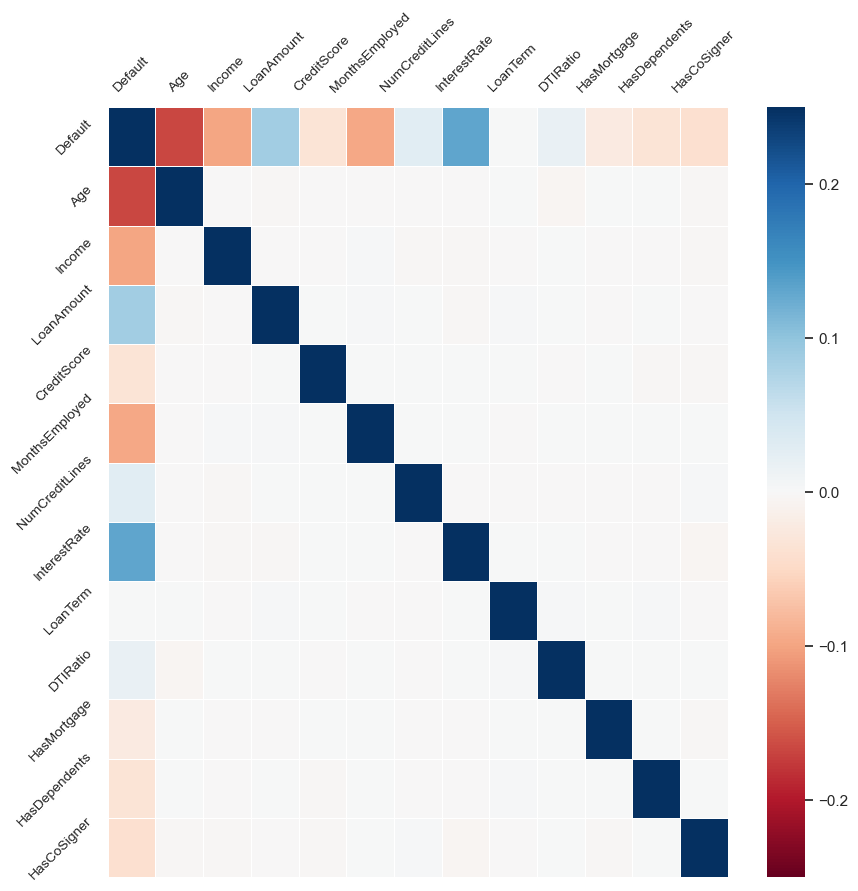

In [6]:
cols = df.columns.tolist()
cols_new = cols[-1:] + cols[:-1] # Move last column to first column
df = df[cols_new] # Overwrite existing dataframe

df_corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.set()
ax=sns.heatmap(df_corr,
            vmin=-0.25,
            vmax=0.25,
            cmap='RdBu',
            center = 0,
            # annot=True, # Running into issues with Seaborn showing annotations properly. Apparently requires downgrading matplotlib.
            fmt=".5f",
            linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, rotation=45)

The above plot indicates a negative correlation between age and income with default. Similarly, it indicates a positive correlation with interest rate and loan amount.

Note however there is relatively weak correlation between these features as indicated by the restricted correlation legend from [-0.25, 0.25]. It is also valuable to note there is no strong colinearity between variables, so no features will be removed for our analysis. Note we will perform feature engineering as an exploration of modeling approaches.

### Distributions (histograms) of Features
Next we can examine the distributions of the important features themselves. This can indicate any outliers or other skew within the features, which may create unintended bias during modeling.

First we plot the histograms for our numerical features. 

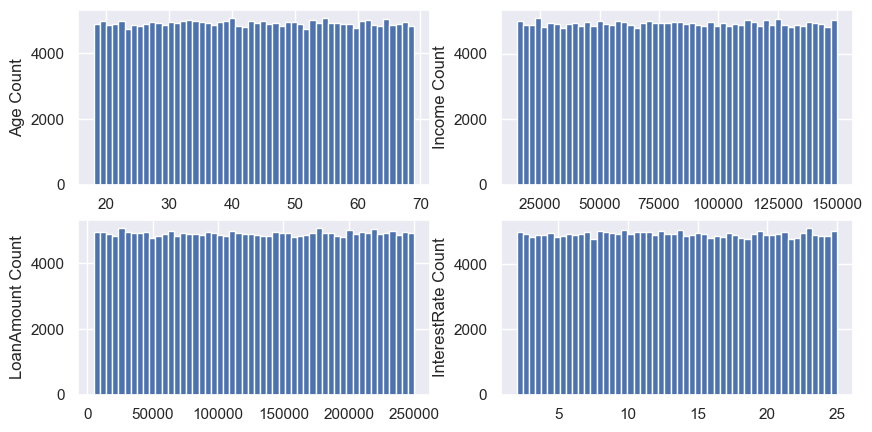

In [7]:
plt.figure(figsize=(10,5))

features = ["Age", "Income", "LoanAmount", "InterestRate"]

for i,feature in enumerate(features,1):
    plt.subplot(2, 2, i)
    plt.hist(df[feature],bins=52)
    plt.ylabel(str(feature) +' Count')

plt.show()

These plots indicate uniform distributions across the the features, which again is convenient for our analysis but may not be representative of truly random sampling. Given the large sample size, it is unlikely any individual outlier will significantly skew our results, as affirmed by our uniform distributions.

### Distributions (histograms) of Features - Default Comparison
We can further explore our features by plotting the same histograms with defaults/non-defaults as different series. This should reinforce the correlation effects highlighted in the matrix.

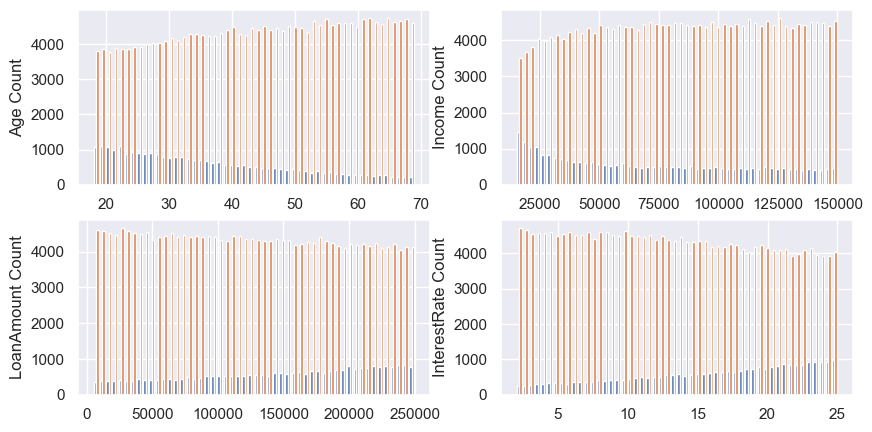

In [8]:
df_defaults = df[df["Default"]==1]
df_non_defaults = df[df["Default"]==-1]

plt.figure(figsize=(10,5))

features = ["Age", "Income", "LoanAmount", "InterestRate"]

for i,feature in enumerate(features,1):
    plt.subplot(2, 2, i)
    plt.hist([df_defaults[feature], df_non_defaults[feature]], bins=52, label=['default', 'non_default'])
    plt.ylabel(str(feature) + ' Count')
plt.show()

These plots make it apparent that as age and income increases, the risk of default decreases, matching our negative correlation from the correlation plot. Likewise, as the loan amount and interest rate increases, the number of defaults increase as indicated by our plot.

These plots also make the skew in labeling more apparent, where only 11.6% of samples are labeled for default.

### Distribution of Features - Categorical
We can also perform similar analysis for categorical variables. Unfortunately we have less insight into categorical variables which do not work with a correlation matrix.

Below are saved images to limit unrelated error messages while generating the plots, though the code is included below. 

In [9]:
# plt.figure(figsize=(10,5))
# plt.subplot(1, 1, 1)
# sns.countplot(x=df.LoanPurpose,hue=df.Default)
# plt.subplot(1, 2, 1)
# sns.countplot(x=df.EmploymentType,hue=df.Default)

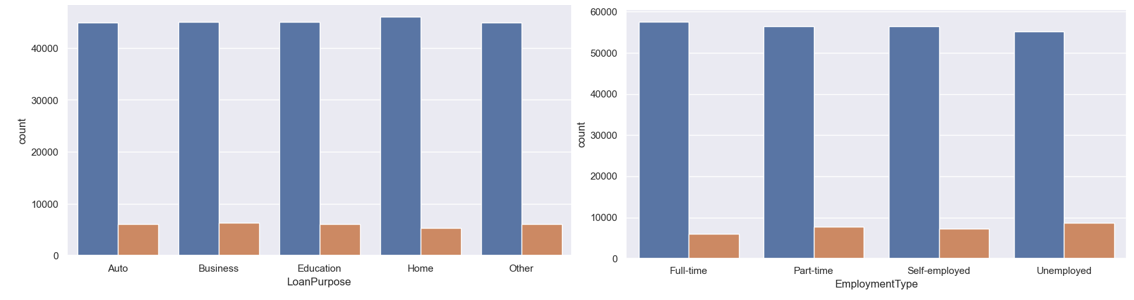

Unlike the continuous variables, it is  challenging to distinguish categorical correlation from these graphs. The below code calculates the default percentage of each category for comparison to our 11.6% baseline.

In [10]:
CategoryDefaultPercents = [] # Initialize
# Iterate through Loan Purpose Categories
for i in df.LoanPurpose.unique():
    percent = 100*df[(df["Default"]==1) & (df["LoanPurpose"].isin([i]))]["Default"].count() / (df[df["LoanPurpose"].isin([i])]["Default"].count())
    CategoryDefaultPercents.append([i,round(percent,3)])
    
# Iterate through Employment Type Categories
for i in df.EmploymentType.unique():
    percent = 100*df[(df["Default"]==1) & (df["EmploymentType"].isin([i]))]["Default"].count() / (df[df["EmploymentType"].isin([i])]["Default"].count())
    CategoryDefaultPercents.append([i,round(percent,3)])
    
# Clean up for presentation
CategoryDefaultPercents = np.array(CategoryDefaultPercents)
print(CategoryDefaultPercents)

[['Other' '11.789']
 ['Auto' '11.881']
 ['Business' '12.326']
 ['Home' '10.235']
 ['Education' '11.838']
 ['Full-time' '9.463']
 ['Unemployed' '13.553']
 ['Self-employed' '11.462']
 ['Part-time' '11.965']]


From these percentages, we can see Loan Purpose "Business" have above average default rates of 12.3% while "Home" loans are below average at 10.2%.
Similarly, we see the Employment Type "Full-time" have below average default rates of 9.5% while Unemployed have above average default rates of 13.5%.

### Exploratory Data Analysis Summary
This initial analysis established some baseline expectations for our decision tree. We became aware of potential label balance concerns to evaluate in our model analysis which will be addressed by supplying sample weights to our models. Our correlation matrix indicated Age, Income, and Interest Rate as important features which should be reflected in our model. While our data may be unrealistically uniformally distributed, it indicates no dramatic outliers or bias to rectify. We confirmed the expected correlations using histograms and compared evaluation approaches for categorical variables which do not follow the same correlation calculations. We identified Full-time/Unemployed and Business/Home loan categories deviating most from our baseline 11.6% default average.

## Models
We will use a staged approach to develop our binary classification model. We will first split our data into a training/testing set and evaluate the performance of a single decision tree. We will prune this single tree by tuning ccp_alpha, which will also inform our important features.

Following our single decision tree, we will evaluate the two decision tree ensemble methods, implementing AdaBoost and Random Forest methods. We will experiment with hyperparameters to consider their effects on model accuracy before finally comparing the different methods' performance.

### Single Decision Tree
The following code first encodes our categorical data to work with our DecisionTree Classifier. It then splits our data into our standard 80/20 training/testing data set. We then build a single decision tree to maximum depth, which we will prune by varying max depth to see its effects on accuracy. Note the class_weight specification in our Decision Tree Classifier to consider label balance.

In [11]:
# Making our categorical variables numeric instead of strings 
le = sk.preprocessing.LabelEncoder()
df['Education'] = le.fit_transform(df.Education.values)
df['EmploymentType'] = le.fit_transform(df.EmploymentType.values)
df['MaritalStatus'] = le.fit_transform(df.MaritalStatus.values)
df['LoanPurpose'] = le.fit_transform(df.LoanPurpose.values)

# Function to split our data
def data_split(data,test_split=0.2):
    feature_names = list(data.iloc[:0,1:])
    Y = data.iloc[:,:1].copy() # Isolate Labels
    X = data.iloc[:,1:].copy() # Isolate Features
    # print(X.head)
    # print(Y.head)
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = test_split, shuffle=False)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    return X_train, X_test, y_train, y_test, feature_names
    
def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes = None, ccp_alpha=0.0):
    clf = sk.tree.DecisionTreeClassifier(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, ccp_alpha = ccp_alpha, class_weight = {-1:1, 1:7.6})
    clf.fit(data_X,data_y)
    return clf

X_train, X_test, y_train, y_test, label_names = data_split(data = df)

clf = build_dt(X_train, y_train)
y_model = clf.predict(X_test)

In [12]:
print("Max Depth:", clf.tree_.max_depth)
print("N Leaves:", clf.tree_.n_leaves)
print("Accuracy: %.3f" % sk.metrics.accuracy_score(y_test,y_model))
print('AUC = %.2f' % sk.metrics.roc_auc_score(y_test, y_model))

Max Depth: 45
N Leaves: 25955
Accuracy: 0.815
AUC = 0.55


Our resulting unpruned tree has a max depth of 45 with between 25000-26000 leaves. The unpruned tree provides an 81.6% test accuracy, however the AUC is much lower at 0.55. This large discrepancy indicates label bias may be a significant factor when evaluating our model, and as such we will use AUC as our evaluation metric going forward.

#### Effects of Max Depth
Let's consider the effects of pruning the tree's maximum tree depth on our training and testing AUC.

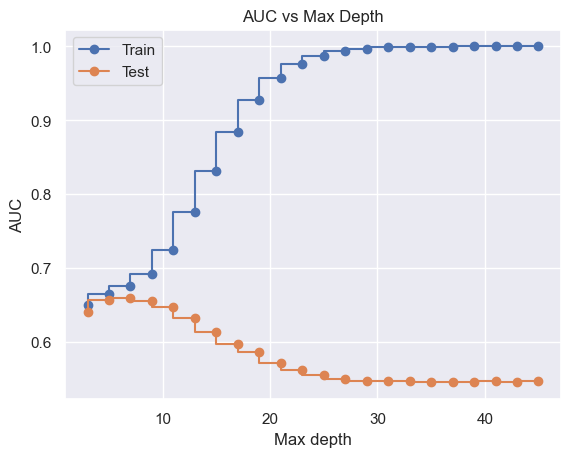

Max Test AUC 0.660


In [13]:
depth_tests = range(clf.tree_.max_depth,1,-2)

clfs = []
for i in depth_tests:
    clfs.append(build_dt(X_train,y_train,max_depth=i))

train_scores = []
test_scores = []
for i in range(len(clfs)):
    model = clfs[i]
    y_model_training = model.predict(X_train)
    y_model_test = model.predict(X_test)
    train_scores.append(sk.metrics.roc_auc_score(y_train,y_model_training))
    test_scores.append(sk.metrics.roc_auc_score(y_test,y_model_test))

fig, ax = plt.subplots()
ax.set_xlabel("Max depth")
ax.set_ylabel("AUC")
ax.set_title("AUC vs Max Depth")
ax.plot(depth_tests, train_scores, marker='o', label="Train",drawstyle="steps-post")
ax.plot(depth_tests, test_scores, marker='o', label="Test",drawstyle="steps-post")
ax.legend()
plt.show()

print("Max Test AUC %.3f" % max(test_scores))

Our Max Depth plot shows our bias/variance gap quite nicely. As max depth increases, we improve our fit on the training data though it is quickly overfit which punishes test data AUC. Pruning the tree, an ideal maximum depth occurs near a depth of 7.

We will set our decision tree baseline AUC at 0.54 and our pruned tree evaluation metric at 0.66 for later comparison to the ensemble methods.

### AdaBoost Decision Tree
With our single decision tree baseline established, we will now implement the first of our two ensemble methods: AdaBoost. We will use stumps of max depth 1 and compare the accuracy as we increase the number of trees, up to 100 learners in 10 learner increments. 

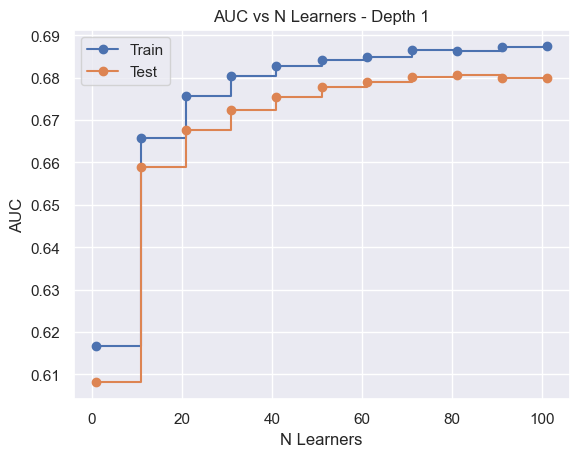

Max Test AUC 0.681


In [14]:
learners = 100
plot_x = range(1,learners+2,10)

X_train, X_test, y_train, y_test, label_names = data_split(data = df,test_split=0.2)

train_scores = []
test_scores = []

for i in plot_x: # Note this could likely be performed using Grid Search 
    ada_clf = ensemble.AdaBoostClassifier(sk.tree.DecisionTreeClassifier(max_depth = 1, class_weight = {-1:1, 1:7.6}), n_estimators = i)
    ada_clf.fit(X_train,y_train)
    train_scores.append(sk.metrics.roc_auc_score(y_train,ada_clf.predict(X_train)))
    test_scores.append(sk.metrics.roc_auc_score(y_test,ada_clf.predict(X_test)))


fig, ax = plt.subplots()
ax.set_xlabel("N Learners")
ax.set_ylabel("AUC")
ax.set_title("AUC vs N Learners - Depth 1")
ax.plot(plot_x, train_scores, marker='o', label="Train",drawstyle="steps-post")
ax.plot(plot_x, test_scores, marker='o', label="Test",drawstyle="steps-post")
ax.legend()
plt.show()

print("Max Test AUC %.3f" % max(test_scores))

Here we see the expected increase in training and test accuracy from additional learners. Also not the gradually marginal improvements with each additional learner. 

Adaboost performed better than our base decision tree, approaching AUC of 0.68 with 81 learners. We see that the model begins to overfit near this point as well test accuracy begins to decline.

#### AdaBoost - Feature Engineering
Let's also consider if we 'massage' our available features based on the resulting feature importance, in particular Age, Income, Interest Rate, Loan Amount, and Months Employed determined by our original decision tree.

Again note we do not have significant colinearity between features, so I do not expect feature engineering to improve our AdaBoost model. Instead, I expect feature engineering will likely degrade our performance by not including other marginally important features.

In [15]:
importance = list(zip(label_names, clf.feature_importances_))
importance = sorted(importance, key=lambda x: x[1], reverse=True)
importance = np.array(importance)
print(importance[0:5,:])

[['InterestRate' '0.14265587712406963']
 ['Income' '0.13407813560555512']
 ['LoanAmount' '0.12389826968300335']
 ['Age' '0.1232693948417002']
 ['CreditScore' '0.10590650888489339']]


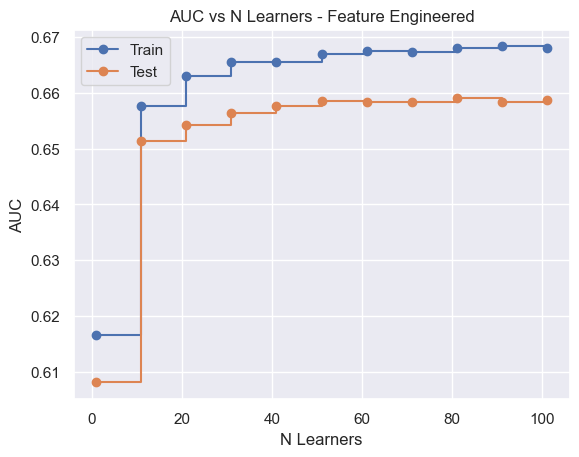

Max Test AUC 0.659


In [16]:
less_df = df[["Default","InterestRate","Income","LoanAmount","Age","CreditScore"]]

learners = 100
plot_x = range(1,learners+2,10)

X_train, X_test, y_train, y_test, label_names = data_split(data = less_df, test_split=0.2)

train_scores = []
test_scores = []

for i in plot_x: 
    ada_clf_feat = ensemble.AdaBoostClassifier(sk.tree.DecisionTreeClassifier(max_depth = 1, class_weight = {-1:1, 1:7.6}), n_estimators = i)
    ada_clf_feat.fit(X_train,y_train)
    train_scores.append(sk.metrics.roc_auc_score(y_train,ada_clf_feat.predict(X_train)))
    test_scores.append(sk.metrics.roc_auc_score(y_test,ada_clf_feat.predict(X_test)))

fig, ax = plt.subplots()
ax.set_xlabel("N Learners")
ax.set_ylabel("AUC")
ax.set_title("AUC vs N Learners - Feature Engineered")
ax.plot(plot_x, train_scores, marker='o', label="Train",drawstyle="steps-post")
ax.plot(plot_x, test_scores, marker='o', label="Test",drawstyle="steps-post")
ax.legend()
plt.show()

print("Max Test AUC %.3f" % max(test_scores))

As expected, we see that the feature engineered plot follows the original AdaBoost plot closely, but provides lower overall AUC since other major factors (ex. MonthsEmployed and DTIRatio) are no longer considered. Also note the feature engineered model more quickly overfits the data, causing the degredation of test accuracy as learners increase.

While the feature engineered version is not as effective as the base decision tree, it is worth considering the runtime benefits of engineering the features at the expense of accuracy.

### Random Forest
Finally let's compare our results to a Random Forest ensemble method. Our random forest will first be composed of stumps of max depth = 1, then incrementally increase depth to try to improve accuracy.

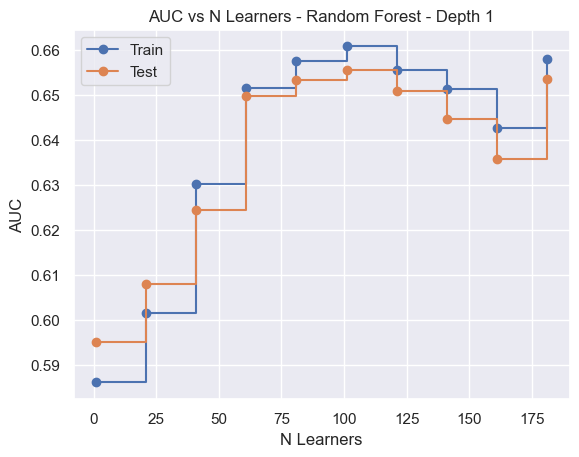

Max Test AUC 0.656


In [17]:
learners = 200
plot_x = range(1,learners+1,20)

X_train, X_test, y_train, y_test, label_names = data_split(data = df,test_split=0.2)

train_scores = []
test_scores = []

for i in plot_x: # Note we are iterating through n estimators since Random Forest doesn't provide a staged score.
    rf_clf = ensemble.RandomForestClassifier(n_estimators = i, max_depth=1, class_weight = {-1:1, 1:7.6})
    rf_clf.fit(X_train,y_train)
    train_scores.append(sk.metrics.roc_auc_score(y_train,rf_clf.predict(X_train)))
    test_scores.append(sk.metrics.roc_auc_score(y_test,rf_clf.predict(X_test)))


fig, ax = plt.subplots()
ax.set_xlabel("N Learners")
ax.set_ylabel("AUC")
ax.set_title("AUC vs N Learners - Random Forest - Depth 1")
ax.plot(plot_x, train_scores, marker='o', label="Train",drawstyle="steps-post")
ax.plot(plot_x, test_scores, marker='o', label="Test",drawstyle="steps-post")
ax.legend()
plt.show()

print("Max Test AUC %.3f" % max(test_scores))

Our random forest of stumps generally performs better than our unpruned decision tree, but does not have the smooth gradual increase as found in AdaBoost. Even an significantly more N learners, the random forest does not perform better than AdaBoost or our pruned decision tree.

Let's consider if we increase the max depth slightly to 5.

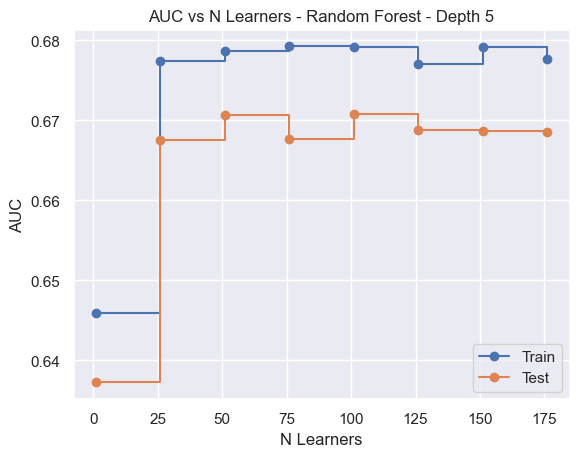

Max Test AUC 0.671


In [18]:
learners = 200
plot_x = range(1,learners+1,25)

X_train, X_test, y_train, y_test, label_names = data_split(data = df,test_split=0.2)

train_scores = []
test_scores = []

for i in plot_x: # Note we are iterating through n estimators since Random Forest doesn't provide a staged score.
    rf_clf = ensemble.RandomForestClassifier(n_estimators = i, max_depth=5, class_weight = {-1:1, 1:7.6})
    rf_clf.fit(X_train,y_train)
    train_scores.append(sk.metrics.roc_auc_score(y_train,rf_clf.predict(X_train)))
    test_scores.append(sk.metrics.roc_auc_score(y_test,rf_clf.predict(X_test)))


fig, ax = plt.subplots()
ax.set_xlabel("N Learners")
ax.set_ylabel("AUC")
ax.set_title("AUC vs N Learners - Random Forest - Depth 5")
ax.plot(plot_x, train_scores, marker='o', label="Train",drawstyle="steps-post")
ax.plot(plot_x, test_scores, marker='o', label="Test",drawstyle="steps-post")
ax.legend()
plt.show()

print("Max Test AUC %.3f" % max(test_scores))

Here we do see marginal improvement in test accuracy, reasonably due to the increased complexity of each learner tree. However, the improvement is still very incremental and likely has high operational costs compared to the simpler pruned decision tree and AdaBoost methods.

## Results and Analysis Summary
Much of the projects's results, iterations, and analysis are provided above, but below summarizes the AUC metrics for the various models:

|Model|Max Test AUC|
|---|---|
|Decision Tree (Depth: 45)|0.55|
|Pruned Decision Tree (Depth: 7) |0.660|
|AdaBoost Ensemble (N:81)|0.681|
|AdaBoost Feature Eng. (N: 81)|0.659|
|Random Forest (N:200 Depth:1)| 0.656|
|Random Forest (N:50 Depth:5)| 0.671|

The pruned decision tree seems surprisingly ideal for this data set, especially considering the simplicity of a single decision tree model. It is reassuring AdaBoost and Random Forest improve accuracy from the base tree, though not as dramatically as I expected. Random Forest is likely not suited to the data set since there are few features and thus random feature sampling is not as influential. Similarly, AdaBoost may be costly to use since weight is widely distributed across hundreds of thousands of data points.

Increasing tree depth improved accuracy as expected, but it is challenging to evaluate each model by varying only maximum depth. The depth of trees may have been central to an accurate model due to the large ratio of samples to features. I believe the large number of samples limits potential for high model variance, so the AdaBoost and Random Forest approaches intended to reduce model variance aren't as effective for this type of dataset.

One suprise through this analysis was the effects of label balance on the resulting models. Initial labels were not rebalanced, which led to concerns that accuracy stemmed solely from over-classification of the majority class. Thus, exploring of alternative evaluation metrics (in this analysis, AUC and checking confusion matrices during development) indicated poor label balance resulting in misrepresentative accuracy. 

## Discussion and Conclusion
The largest takeaway from this project is the importance of experimenting with methods. In general I expected AdaBoost and Random Forest to perform far better than the decision tree benchmark, but again I believe the data with many samples inherently have lower model variance but significant complexity to be classified with only stumps.

As mentioned, the second large takeaway was label balance. It became very apparent once class weights were added how differently an algorithm will solve. I began the project unsure if an 11.6%/88.4% split was significant enough to require rebalancing, but have now seen through experience the importance of label balancing. 

An experiment which didn't work well was tuning the hyperparameter ccp alpha to prune the decision tree. I believe this comes as a consequence of the decision tree complexity where there were too many unique ccp alpha points to evaluate each alpha value as we did in previous assignments. These tests are included as an appendix as they weren't especially insightful for the main report. You'll find a plot of CCP alpha and the number of values, and you can see why incrementally changing CCP alpha would be challenging as a pruning parameter.

Future improvements to this project could compare label rebalancing methods, either using class weights as done here or by manipulating the dataset itself. It would also be interesting to consider the accuracy/operating tradeoffs of each methods. The programs could run quite slowly during the project as it would redundantly regenerate ensemble forests to evaluate the various models, which seemed especially taxing for this large dataset. In this case, the additional runtime may not be worth the very marginal accuracy improvement. Finally, in an effort to streamline and operate efficiently, I would invest more time into learning GridSearch to perform hyperparameter sensitivity, especially in multi-parameter exploration. As mentioned, the current code redundantly creates many cases for sensitivity analysis which ideally is handled better by GridSearch.

## Appendix:

#### Effects of ccp_alpha
Let's explore the effects of varying ccp_alpha on our decision tree's accuracy performing similar fits. 

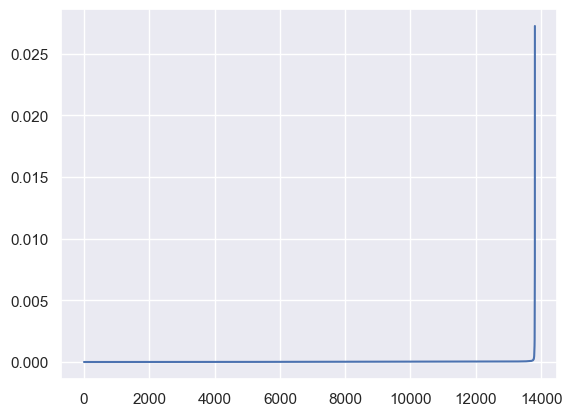

In [19]:
path = clf.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

max_ccp = max(ccp_alphas)
plt.plot(range(len(ccp_alphas)),ccp_alphas)

ccp_alphas = np.linspace(max_ccp,0,5)

clfs = []
for i in ccp_alphas:
    clfs.append(build_dt(X_train,y_train,ccp_alpha=i))

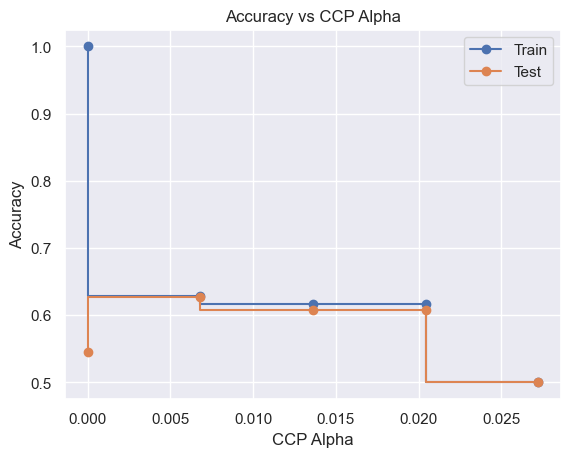

In [20]:
train_scores = []
test_scores = []

for i in range(len(clfs)):
    model = clfs[i]
    y_model_training = model.predict(X_train)
    y_model_test = model.predict(X_test)
    train_scores.append(sk.metrics.roc_auc_score(y_train,y_model_training))
    test_scores.append(sk.metrics.roc_auc_score(y_test,y_model_test))

fig, ax = plt.subplots()
ax.set_xlabel("CCP Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs CCP Alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="Train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="Test",drawstyle="steps-post")
ax.legend()
plt.show()

This plot is interesting as it reveals a large accuracy penalty on the training data by overfitting with 0 ccp_alpha.